### What is Batch Normalization..?

**Basically, Batch Norm is the normalization of the output in each hidden layer**

The problem is that during SGD training, the distribution of weights W and/or the inputs to a hidden layer  can vary widely from iteration to iteration. 

Naturally, neural networks including deep networks require careful tuning of weight initialization and learning parameters. Batch normalization helps relaxing them a little.

### Why do we use batch normalization?
We normalize the input layer by adjusting and scaling the activations. For example, when we have features from 0 to 1 and some from 1 to 1000, we should normalize them to speed up learning. If the input layer is benefiting from it, why not do the same thing also for the values in the hidden layers, that are changing all the time, and get 10 times or more improvement in the training speed.


Batch normalization reduces the amount by what the hidden unit values shift around (covariance shift). To explain covariance shift, let’s have a deep network on cat detection. We train our data on only black cats’ images. So, if we now try to apply this network to data with colored cats, it is obvious; we’re not going to do well. The training set and the prediction set are both cats’ images but they differ a little bit. In other words, if an algorithm learned some X to Y mapping, and if the distribution of X changes, then we might need to retrain the learning algorithm by trying to align the distribution of X with the distribution of Y. ( Deeplearning.ai: Why Does Batch Norm Work?

**Batch normalization is a method we can use to normalize the inputs of each layer..**

During training time, a batch normalization layer does the following:

<img src='../images/bn.PNG' width='40%' height='40%'/>

**Notice that γ and β are learned during training along with the original parameters of the network.**

<img src='../images/batch-normalization.jpg' width='70%' height='70%'/>


Batch normalization (BN) solves a problem called internal covariate shift, so to explain why BN helps we’ll need to first understand what covariate shift actually is…

“Covariates” is just another name for the input “features”, often written as X. 
Covariate shift means the distribution of the features is different in different parts of the training/test data..

In [1]:
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
tf.set_random_seed(1)
np.random.seed(1)

n_samples = 2000
batch_size = 64
epoch =12
LR = .03
N_hidden = 8
activation = tf.nn.tanh
b_init = tf.constant_initializer(-0.2)

In [3]:
### train_data
X = np.linspace(-7,10,n_samples)[:,np.newaxis]
np.random.shuffle(X)
noise = np.random.normal(0,2,X.shape)

Y = np.square(X)- 5 + noise

train_data = np.hstack((X,Y))

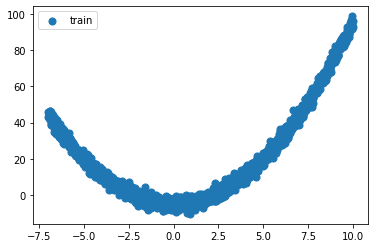

In [4]:
# test data
test_x = np.linspace(-7, 10, 200)[:, np.newaxis]
noise = np.random.normal(0, 2, test_x.shape)
test_y = np.square(test_x) - 5 + noise

# plot input data
plt.scatter(X, Y, s=50,label='train')
plt.legend(loc='upper left')


In [5]:
tf_x = tf.placeholder(tf.float32,[None,1])
tf_y = tf.placeholder(tf.float32,[None,1])

tf_is_train = tf.placeholder(tf.bool,None)
#flag on using BN on training or testing

In [7]:
m = tf.random_normal((10,1))
m

<tf.Tensor 'random_normal_1:0' shape=(10, 1) dtype=float32>

In [8]:
z=[m]
z

[<tf.Tensor 'random_normal_1:0' shape=(10, 1) dtype=float32>]

In [9]:
z[-1]

<tf.Tensor 'random_normal_1:0' shape=(10, 1) dtype=float32>

In [10]:
sess = tf.Session()
s=sess.run(z)

In [11]:
s[-1]

array([[-0.47795692],
       [ 0.88442147],
       [-0.62377393],
       [-0.951011  ],
       [-0.9606378 ],
       [ 1.4638727 ],
       [ 0.9194197 ],
       [ 0.26994547],
       [-0.01896318],
       [-1.9707651 ]], dtype=float32)

In [12]:
sess.close()

**TRAINABLE_VARIABLES** is the collection of variables or training parameters which should be modified when minimizing the loss.
For example, these can be the weights determining the function performed by each node in the network. 

This happens(a variable updated) automatically when we define a new variable with tf.get_variable, unless you specify

tf.get_variable(..., trainable=False)

### Parameters in Batch Normalization

- **Training** :Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). NOTE: make sure to set this parameter correctly, or else our training/inference will not work properly.

- **trainable**: Boolean, if True also add variables to the graph collection GraphKeys.TRAINABLE_VARIABLES 

**Note:** When is_bn is True the moving_mean and moving_variance need to be updated, by default the update_ops are placed in tf.GraphKeys.UPDATE_OPS so they need to be added as a dependency to the train_op, 

when we execute an operation (such as train_step), only the subgraph components relevant to train_step will be executed. 
Unfortunately, the update_moving_averages operation is not a part of train_step in the computational graph, so we will never update the moving averages!
To get around this, we have to explicitly tell the graph:

Hey graph, update the moving averages before you finish the training step!

**UPDATE_OPS**

UPDATE_OPS is a collection of ops (operations performed when the graph runs, like multiplication, ReLU, etc.), not variables. Specifically, this collection maintains a list of ops which need to run before each training step.

**How do ops get added to this collection?**
By definition, update_ops occur outside the regular flow of training by loss minimization, so generally we will be adding ops to this collection only under special circumstances. For example, when performing batch normalization, we want to recompute the batch mean and variance before each training step, and this is how it's done.

**control_dependencies**

It is a mechanism to add dependencies to whatever ops we create in the with block. More specifically, what you we in the argument to control_dependencies is ensured to be evaluated before anything we define in the with block. 

tf.get_collection(), which can find some tensor that we want.

### How to use batch normalization

Set this to True for training and False for testing

training = tf.placeholder(tf.bool)

x = tf.layers.dense(input_x, units=100)

x = tf.layers.batch_normalization(x, training=training)

x = tf.nn.relu(x)

add the update ops as dependencies of our training op , then just run our training op as normal:

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.control_dependencies(extra_update_ops):

    train_op = optimizer.minimize(loss)
    
...

sess.run([train_op], ...)

In [13]:
class NN():
    def __init__(self,batch_normalization = False):
        
        self.is_bn = batch_normalization
        self.w_init = tf.random_normal_initializer(0.,.1)  #weight initialization
        self.pre_activation = [tf_x]
        
        if self.is_bn:
            self.layer_input = [tf.layers.batch_normalization(tf_x, training=tf_is_train)]  
            # for input data
        else:
            self.layer_input = [tf_x]
            
        for i in range(N_hidden):
            self.layer_input.append(self.add_layer(self.layer_input[-1],10,ac=activation))

        
        self.out = tf.layers.dense(self.layer_input[-1], 1,kernel_initializer=self.w_init,
                                   bias_initializer=b_init)
        
        self.loss = tf.losses.mean_squared_error(tf_y,self.out)
        
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            self.train = tf.train.AdamOptimizer(LR).minimize(self.loss)


            
    def add_layer(self,x,out_size,ac=None):

        x = tf.layers.dense(x, out_size,kernel_initializer=self.w_init,
                            bias_initializer=b_init)
        
        self.pre_activation.append(x)
        if self.is_bn: 
            x = tf.layers.batch_normalization(x,momentum=0.4, training=tf_is_train)
            
        if ac is None:
            out = x
        else:
            out = ac(x)
        return out
        

In [15]:
nets = [NN(batch_normalization=False), NN(batch_normalization=True)]    
# two nets, with and without BN

In [16]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [17]:
train_data[-5:]

array([[ 8.23111556, 63.95106741],
       [ 2.32066033, -0.97123177],
       [ 9.43021511, 84.94684712],
       [-5.00150075, 21.09153939],
       [ 2.02301151, -0.15835713]])

In [18]:
losses = [[], []]   # record test loss

for e in range(1,21):
    np.random.shuffle(train_data)
    j=1
    tr_l0=0
    tr_l1=0
    for i in range(n_samples//batch_size):
        offset = i*batch_size
        
        b_x = train_data[offset:batch_size*j,0:1]
        b_y = train_data[offset:batch_size*j,1:2]
        _,_,tr_loss_0,tr_loss_1=sess.run([nets[0].train, nets[1].train,nets[0].loss,nets[1].loss], {tf_x: b_x, tf_y: b_y, tf_is_train: True})
        j=j+1
        tr_l0 +=tr_loss_0
        tr_l1 +=tr_loss_1
    if e % 5 ==0:
        print('without BN loss:{} and with BN loss:{}'.format(tr_l0,tr_l1))
        
        
    loss_0,loss_1 = sess.run([nets[0].loss,nets[1].loss],{tf_x: test_x, tf_y: test_y, 
                                                              tf_is_train: False})
    
    for loss,k in zip(losses,(loss_0,loss_1)):
        loss.append(k)

without BN loss:21504.62908935547 and with BN loss:8487.575927734375
without BN loss:21389.73599243164 and with BN loss:3051.572093963623
without BN loss:21479.209228515625 and with BN loss:2149.0923252105713
without BN loss:21459.442932128906 and with BN loss:1212.4155769348145


In [19]:
import pandas as pd

In [20]:
df = pd.DataFrame(losses).T
newdf = pd.DataFrame()
newdf["Without BNM"] = df.iloc[:,0]
newdf["With BNM"] = df.iloc[:,1]
newdf

Without BNM    With BNM
0    828.017029  825.460999
1    711.696472  559.359314
2    695.444092  423.480072
3    694.824036  301.704865
4    694.917786  220.624420
5    694.823669  171.918243
6    694.852051  164.698639
7    694.824219  108.933197
8    694.842346   79.913292
9    694.874634   80.087204
10   694.960083  142.396500
11   694.836792   61.344952
12   694.825928   41.656925
13   694.878418   50.295048
14   695.042053   76.798744
15   694.833496   39.337494
16   694.838440  122.879295
17   694.925964   48.790470
18   694.852051   58.104504
19   694.948425   33.293751

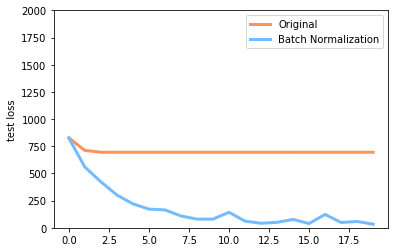

In [21]:
plt.figure(1)
plt.plot(losses[0], c='#FF9359', lw=3, label='Original')
plt.plot(losses[1], c='#74BCFF', lw=3, label='Batch Normalization')
plt.ylabel('test loss') 
plt.ylim((0, 2000)) 
plt.legend(loc='best')

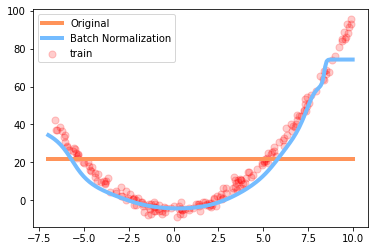

In [25]:
pred, pred_bn = sess.run([nets[0].out, nets[1].out], {tf_x: test_x, tf_is_train: False})

plt.plot(test_x, pred, c='#FF9359', lw=4, label='Original')
plt.plot(test_x, pred_bn, c='#74BCFF', lw=4, label='Batch Normalization')
plt.scatter(X[:200], Y[:200], c='r', s=50, alpha=0.2, label='train')
plt.legend(loc='best')
plt.show()

In [26]:
sess.close()